In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import uncertainties as unc
import os

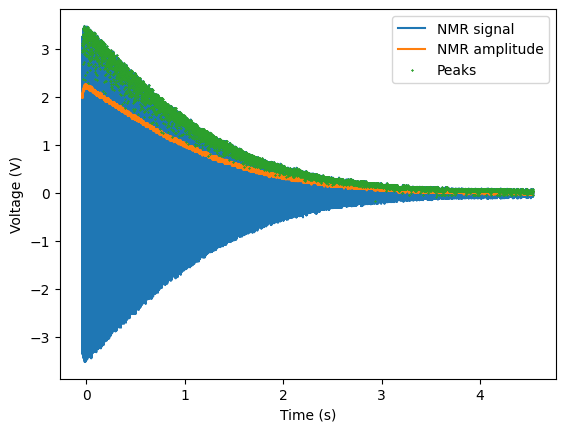

T2 = 1.2196±0.0009s


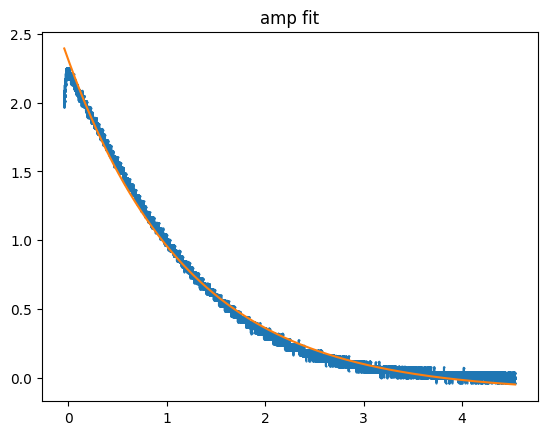

T2 = 1.214±0.004s


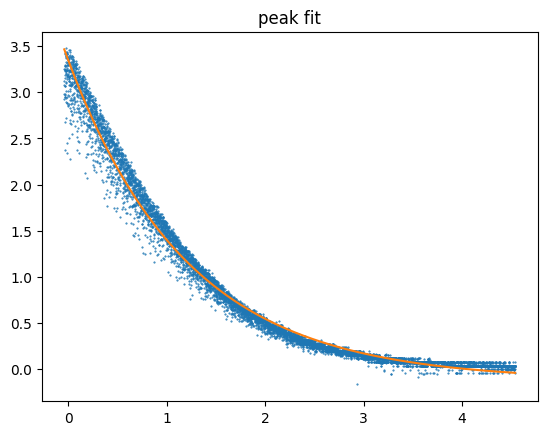

In [123]:
class NMR_data:
    def __init__(self, filepath, cutoff_below=None):
        """cutoff: load data only after the first value above the cutoff"""

        self.file = filepath
        df = pd.read_csv(filepath, skiprows=[1])
        df = df.replace([np.inf, -np.inf, np.nan], 0) # remove these cus the curve_fit doesn't like them

        if cutoff_below:
            start_index = df[df['4'] > cutoff_below].index[0]
            df_filtered = df.iloc[start_index:]
            df_filtered = df_filtered.reset_index(drop=True)
            self.df = df_filtered
        else:
            self.df = df

        self.time = self.df["x-axis"] # s
        self.signal = self.df["2"] # V
        self.amplitude = self.df["4"] # V


def t2_function(t, A, B, T2):
    return A * np.exp(-t/T2) + B

def find_signal_peaks(data):
    peaks, _ = find_peaks(data.signal.values)
    peak_times = data.time.values[peaks]
    peak_magnitudes = data.signal[peaks]
    return peak_times, peak_magnitudes

data1 = NMR_data(r"C:\Users\nagyk\OneDrive\2425.1b\Lab4 - NMR\data & processing NMR\raw osc data\nmr-pt4-cv29.91v.csv", 
cutoff_below=2)
plt.plot(data1.time, data1.signal, label='NMR signal')
# plt.plot(data1.time, data1.amplitude*1.6, label='NMR amplitude * 1.6')
plt.plot(data1.time, data1.amplitude, label='NMR amplitude')

peak_times, peak_magnitudes = find_signal_peaks(data1)
plt.plot(peak_times, peak_magnitudes, "x", label='Peaks', markersize=1)

# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
# plt.xlim(0.1, 0.11)

# Show the plot
plt.show()


def t2_fit(data=None, xy=None, show=True):
    if xy:
        x, y = xy
        linestyle='None'
    else:
        x, y = data.time, data.amplitude
        linestyle='-'
    popt, pcov = curve_fit(t2_function, x, y, p0=[np.max(y), 0, 1])
    if show:
        plt.plot(x, y, label='data', marker='.', linestyle=linestyle, markersize=1)    
        plt.plot(x, t2_function(x, *popt), label='fit')

    t2 = unc.correlated_values(popt, pcov)[2]
    return t2


print(f"T2 = {t2_fit(data=data1):.1uP}s")
plt.title('amp fit')
plt.show()
print(f"T2 = {t2_fit(xy=[peak_times, peak_magnitudes]):.1uP}s")
plt.title('peak fit')
plt.show()



In [120]:
def analyze_nmr_data(file_path, cutoff_below=2, show=True):
    """
    Analyze NMR data from a file, plot signals and fits, and calculate T2 values.
    
    Parameters:
    file_path (str): Path to the NMR data file
    cutoff_below (float): Cutoff value for data processing
    
    Returns:
    tuple: (T2_continuous, T2_peaks) - T2 values from continuous and peak fits
    """
    # Load and process data
    data = NMR_data(file_path, cutoff_below=cutoff_below)
    peak_times, peak_magnitudes = find_signal_peaks(data)
    
    t2_amp = t2_fit(data=data, show=show)

    t2_peaks = t2_fit(xy=[peak_times, peak_magnitudes], show=show)


    if show:
        # First plot: Signal and amplitude with peaks
        plt.plot(data.time, data.signal, label='NMR signal')
        plt.plot(data.time, data.amplitude, label='NMR amplitude')
    
        plt.plot(peak_times, peak_magnitudes, "x", label='Peaks')
        
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        plt.legend()
        plt.xlim(0.1, 0.11)
        plt.show()
    
        # Second plot: Continuous amplitude fit
        print(f"T2 (amplitudes) = {t2_amp:.1uP}s")
        plt.title('Amplitude fit')
        plt.show()
        
        # Third plot: Peak fit
        print(f"T2 (peaks) = {t2_peaks:.1uP}s")
        plt.title('Peak fit')
        plt.show()
        
    return t2_amp, t2_peaks


dir_path = r"C:\Users\nagyk\OneDrive\2425.1b\Lab4 - NMR\data & processing NMR\raw osc data"
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
t2s_amp, t2s_peaks = [], []
for file in csv_files:
    full_path = os.path.join(dir_path, file)
    t2_amp, t2_peaks = analyze_nmr_data(full_path,
                    cutoff_below=2,
                    show=False)
    print(f"""File: {file}
          T2 (amplitude): {t2_amp:.1uP}s, 
          T2 (peaks): {t2_peaks:.1uP}s
          
          """)

File: nmr-pt4-cv29.91V-v2.csv
          T2 (amplitude): 1.2808±0.0009s, 
          T2 (peaks): 1.283±0.004s
          
          
File: nmr-pt4-cv29.91V-v3.csv
          T2 (amplitude): 1.2706±0.0009s, 
          T2 (peaks): 1.274±0.004s
          
          
File: nmr-pt4-cv29.91V-v6.csv
          T2 (amplitude): 1.4264±0.0008s, 
          T2 (peaks): 1.414±0.005s
          
          
File: nmr-pt4-cv29.91v.csv
          T2 (amplitude): 1.2196±0.0009s, 
          T2 (peaks): 1.214±0.004s
          
          
